# MediaMatcher -> Comparative Study
Se importan las librerías necesarias

In [75]:
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import cv2 as cv
import argparse
import time
import glob
import sys

# Dataset
Para llevar a cabo un estudio comparativo de calidad donde se obtengan resultados fiables, es necesario
que el dataset que se emplee contenga una cantidad determinada de imágenes. En este caso, se ha elegido
un dataset relacionado con Cocacola que se puede obtener [aquí](https://www.kaggle.com/datasets/serhanayberkkl/pepsi-cocacola-images).

Se carga por separado el logo de cocacola y todo el conjunto de imágenes del dataset de Cocacola

In [76]:
path = './dataset'
images_l = [cv.imread(i, cv.IMREAD_GRAYSCALE) for i in glob.glob(path + '/*')]
logo = cv.imread('./dataset/logo/logo.png', cv.IMREAD_GRAYSCALE)

Se crea un objeto sift y se aplica la técnica sobre el logo

In [77]:
sift = cv.SIFT_create()
logo_kp1, logo_des1 = sift.detectAndCompute(logo, None)

Definimos una función denominada 'matches' donde dada una imagen, se computará los descriptores sift y se obtendrá los matches con respecto al logo.

In [78]:
def matches(img):
    try:
        i = img
        kp2, des2 = sift.detectAndCompute(i, None)

        bf = cv.BFMatcher()  # BFMatcher with default params
        matches = bf.knnMatch(logo_des1, des2, k=2)

        good = []  # Apply ratio test
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good.append([m])

        img3 = cv.drawMatchesKnn(logo, logo_kp1, i, kp2, good, None,
                                 flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        return img3, len(good)
    except:
        print("error")
        return np.array([]), 0

En la siguiente celda, se define el algoritmo y se pone a prueba. La ejecución de esta parte del cuaderno provocará un error relacionado entre la el uso de hilos y la tecnología de jupyter. Por tanto no se puede comprobar. Por tanto, he determinado generar un script con el mismo código y llamarlo desde python. En esta verisón paralelizada se hace uso de multiprocessing y se utiliza un pool de 5 hilos.

In [82]:
if __name__ == '__main__':
    start_parallel = time.time() * 1000
    
    best_img = None
    len_ = 0
    with multiprocessing.Pool(3) as p:
        output = p.map(matches, images_l)
        for i, j in output:
            if j > len_:
                len_, best_img = j, i
    finish_paralell = time.time() * 1000
    print(start_parallel - finish_paralell)


Process SpawnPoolWorker-556:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'matches' on <module '__main__' (built-in)>
Process SpawnPoolWorker-557:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.8/

KeyboardInterrupt: 

Llamada al script en python

In [113]:
p = !python 'mediamatcher.py'
if 'error' == p[0]:
    paralell = float(p[1])
else:
    paralell = float(p[0])
paralell


2260.440673828125

Ahora definimos el algoritmo de manera secuencial

In [94]:
def sequencial():
    start = time.time() * 1000  # for computing time execution program

    best_img = None  #best image found
    best_good = []
    umbral = 10
    for idx, i in enumerate(images_l):
        try:
            kp2, des2 = sift.detectAndCompute(i, None)
            bf = cv.BFMatcher()  # BFMatcher with default params
            matches = bf.knnMatch(logo_des1, des2, k=2)  # detect matches

            good = []  # Apply ratio test
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good.append([m])
            img3 = cv.drawMatchesKnn(logo, logo_kp1, i, kp2, good, None,
                                     flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

            if len(good) > len(best_good) and len(good) >= umbral: 
                best_good = good
                best_img = img3
        except:
            print(f"image {idx} failed!")
    return time.time() * 1000 - start
seq = sequencial()

image 366 failed!


# Resultados

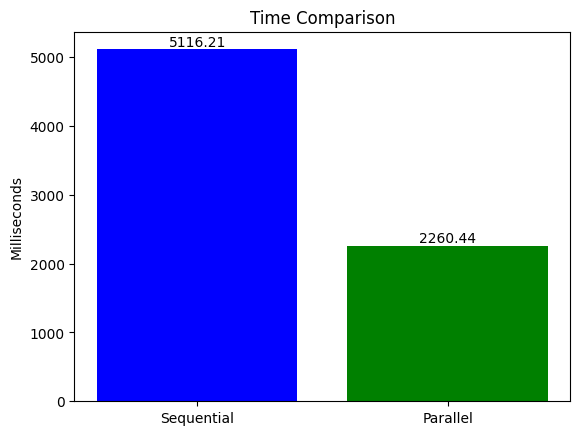

In [114]:
data = [seq, paralell]
labels = ['Sequential', 'Parallel']

# Create a bar plot
bars = plt.bar(labels, data, color=['blue', 'green'])

for bar, value in zip(bars, data):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom')


# Set the title
plt.title('Time Comparison')
plt.ylabel('Milliseconds')

# Show the plot
plt.show()

Como se puede apreciar, la ejecución paralela consigue un rendimiento mejor que la ejecución secuencial. En este caso, la ejecución paralela tarda la mitad de tiempo que tarda la ejecución secuencial. Este hecho, solo puede apreciarse si hay una gran cantidad de imágenes, de lo contrario, la creación de procesos o hilos requiere tantos pasos y recursos que consiguen resultados peores que la ejecución secuencial.